## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
test['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
# anatom_site_general_challenge (NaN)
train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
# Sex
train['sex_mean'] = train['sex'].map(train.groupby(['sex'])['target'].mean())
test['sex_mean'] = test['sex'].map(train.groupby(['sex'])['target'].mean())


# # External features
# train_img_ft = pd.read_csv('../input/landscape/TrainSuperTab.csv')
# test_img_ft = pd.read_csv('../input/landscape/TestSuperTab.csv')
# ext_fts = ['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 
#            'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
#            'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
# for ft in ext_fts:
#     train[ft] = train_img_ft[ft]
#     test[ft] = test_img_ft[ft]

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,sex_enc,sex_mean
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0,1,0.021231
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1,0,0.013766
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2,0,0.013766
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3,0,0.013766
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4,0,0.013766


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.021231
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.021231
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.013766
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.013766
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.013766


# Model

In [6]:
features = ['age_approx', 'sex_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features

# External features
# features += ext_fts
print(features)

['age_approx', 'sex_mean', 'sex_enc']


In [7]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 10)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[train['tfrecord'].isin(idxT)]
        x_valid = train[~train['tfrecord'].isin(idxT)]
        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.6min finished


Best: 0.675187 using {'subsample': 0.51010101010101, 'scale_pos_weight': 13.160578386605785, 'reg_lambda': 0.36734693877551017, 'reg_alpha': 0.9795918367346939, 'max_depth': 2, 'learning_rate': 0.010897034921514772, 'colsample_bytree': 0.9222222222222223}
0.670027 (0.021155) with: {'subsample': 0.5757575757575758, 'scale_pos_weight': 19.240867579908677, 'reg_lambda': 0.673469387755102, 'reg_alpha': 0.9591836734693877, 'max_depth': 5, 'learning_rate': 0.02299496045261219, 'colsample_bytree': 0.9222222222222223}
0.672129 (0.025413) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 4, 'learning_rate': 0.00635439354601029, 'colsample_bytree': 0.7666666666666666}
0.669744 (0.020580) with: {'subsample': 0.8383838383838385, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.4693877551020408, 'reg_alpha': 0.9591836734693877, 'max_depth': 8, 'learning_rate': 0.011785347069983637, 'cols

# Training

In [8]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'validation' if x['tfrecord'] in idxT else 'train', axis=1)    
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], 
              eval_metric='auc', early_stopping_rounds=100, verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Feature importance

Fold: 1


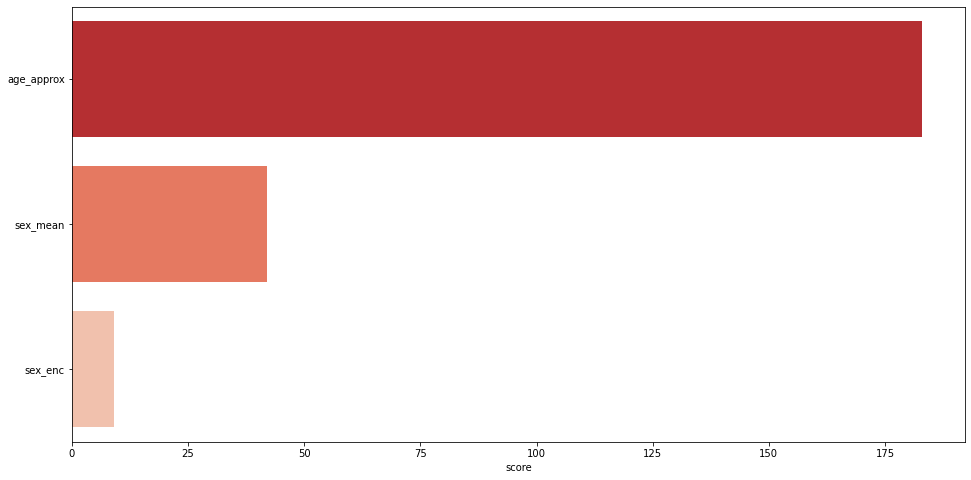

Fold: 2


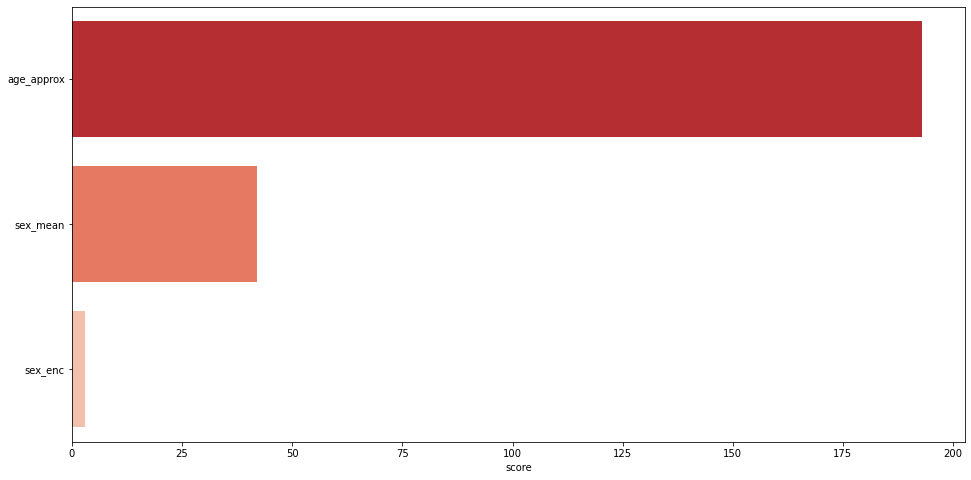

Fold: 3


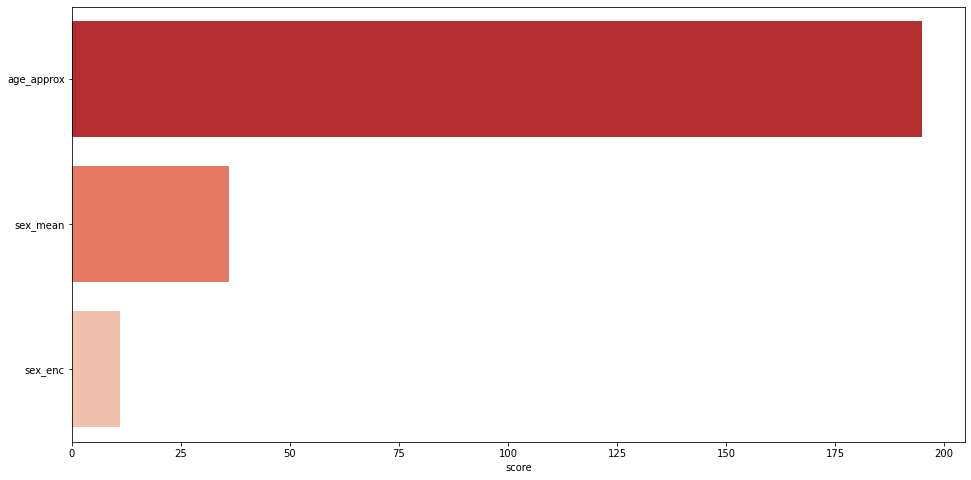

Fold: 4


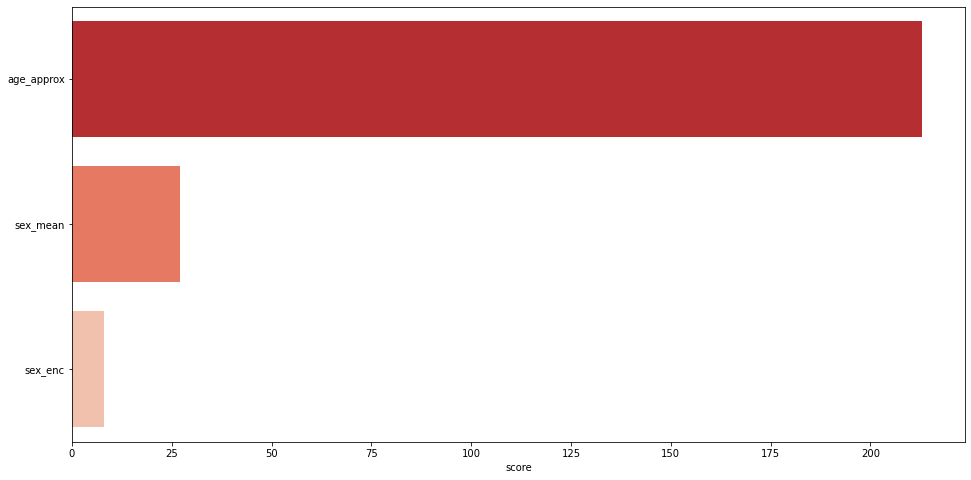

Fold: 5


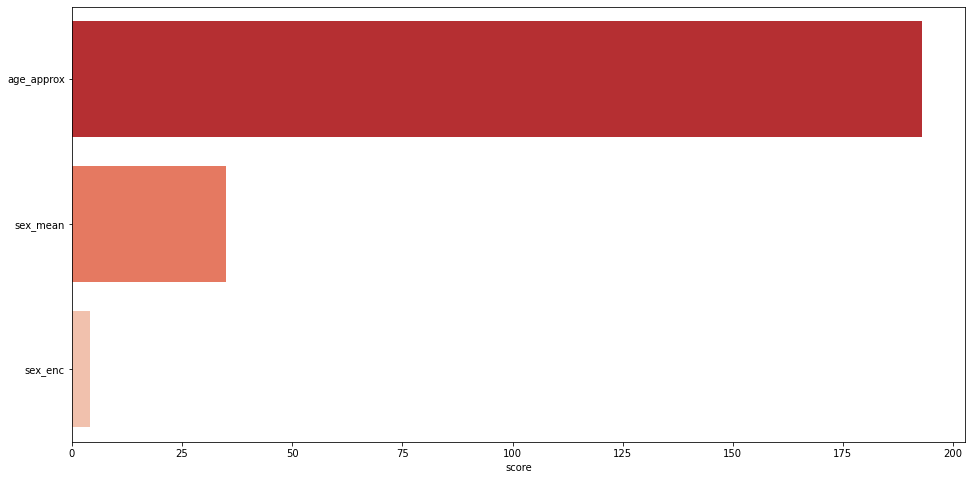

In [9]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [10]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.679200,0.680989,-0.001790,0.694315,0.670235,0.689279,0.680186,0.710799,0.674434,0.626076,0.696707,0.675530,0.683386
Accuracy,0.979833,0.977923,0.001910,0.970445,0.965438,0.981487,0.980771,0.982966,0.982211,0.982012,0.980632,0.982258,0.980564
Precision,0.093643,0.142982,-0.049339,0.051546,0.101633,0.083333,0.220588,0.000000,0.000000,0.000000,0.216216,0.333333,0.176471
Recall,0.016751,0.042592,-0.025841,0.042017,0.120430,0.008403,0.032258,0.000000,0.000000,0.000000,0.034409,0.033333,0.025862
F1-score,0.024434,0.054201,-0.029767,0.046296,0.110236,0.015267,0.056285,0.000000,0.000000,0.000000,0.059369,0.060606,0.045113
Support,119.200000,464.800000,-345.600000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,120.000000,464.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.679200,0.680989,-0.001790,0.694315,0.670235,0.689279,0.680186,0.710799,0.674434,0.626076,0.696707,0.675530,0.683386
male,0.667746,0.670094,-0.002347,0.688600,0.664355,0.755720,0.644783,0.639483,0.680619,0.631802,0.680108,0.623127,0.680602
female,0.660435,0.666500,-0.006066,0.698603,0.641076,0.586361,0.686786,0.742095,0.645508,0.576467,0.693480,0.698648,0.665651
head/neck,0.758155,0.756879,0.001276,0.701528,0.760840,0.855366,0.737480,0.728564,0.768501,0.773086,0.755391,0.732227,0.762182
upper extremity,0.691834,0.693882,-0.002048,0.732031,0.670416,0.698025,0.696967,0.721224,0.684704,0.620823,0.713863,0.687068,0.703462
lower extremity,0.621595,0.615347,0.006248,0.641242,0.600562,0.589978,0.622834,0.667756,0.610283,0.569391,0.632770,0.639608,0.610286
torso,0.675688,0.680667,-0.004980,0.705639,0.666574,0.681751,0.680688,0.696481,0.677001,0.629392,0.694826,0.665176,0.684247
0 <= age < 26,0.547628,0.603406,-0.055778,0.583051,0.609733,0.176815,0.693589,0.530754,0.595624,0.749852,0.538189,0.697671,0.579895
26 <= age < 40,0.582420,0.566615,0.015805,0.584457,0.554788,0.647582,0.564485,0.582616,0.566858,0.518657,0.586641,0.578788,0.560303


# Adversarial Validation

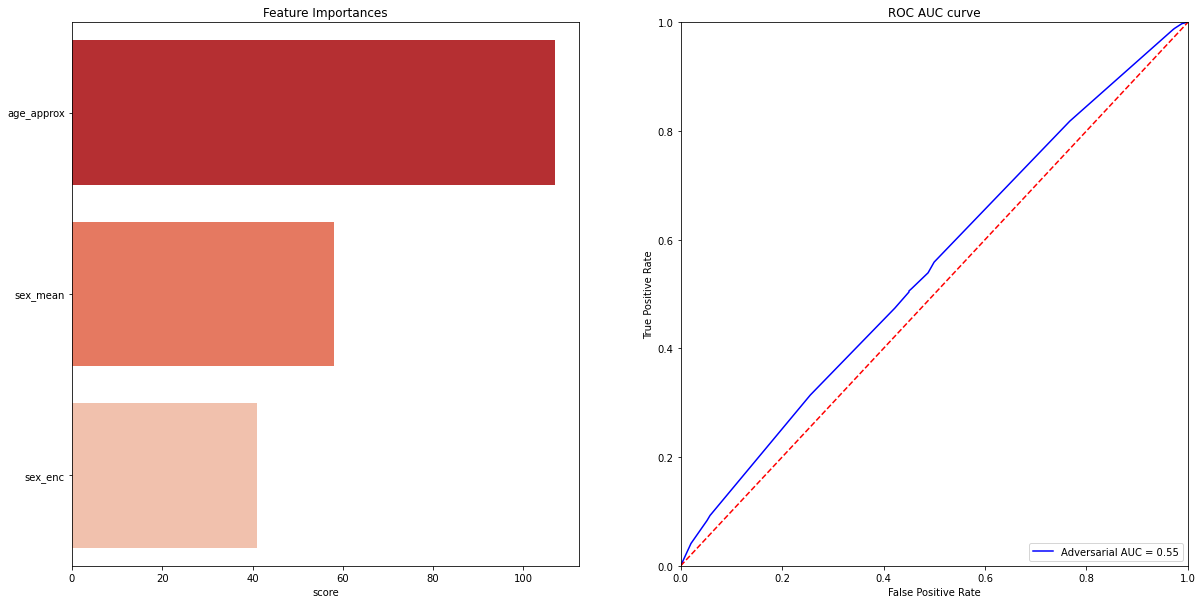

In [11]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [12]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 80
Train positive correct predictions: 16
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.394901,0.488035,0.389042,0.335563,0.358677,0.403191
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.387059,0.487563,0.378508,0.323130,0.349098,0.396993
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.388369,0.488357,0.380561,0.324705,0.351228,0.396993
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.387059,0.487563,0.378508,0.323130,0.349098,0.396993
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.397938,0.488357,0.391661,0.335666,0.368542,0.405464
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.384497,0.487563,0.377661,0.317401,0.343678,0.396183
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.392466,0.488035,0.388185,0.330546,0.353188,0.402376
7,ISIC_0075663,female,35.0,torso,unknown,0,0.384497,0.487563,0.377661,0.317401,0.343678,0.396183
8,ISIC_0075914,male,30.0,torso,unknown,0,0.392301,0.488035,0.388185,0.329720,0.353188,0.402376
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.388369,0.488357,0.380561,0.324705,0.351228,0.396993


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.397938,0.488357,0.391661,0.335666,0.368542,0.405464
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.388369,0.488357,0.380561,0.324705,0.351228,0.396993
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.405906,0.488829,0.402323,0.348333,0.378344,0.411703
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.428956,0.493328,0.425330,0.390454,0.410202,0.425465
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.421709,0.493328,0.418202,0.376398,0.401451,0.419166
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.474168,0.498448,0.455899,0.465216,0.471965,0.479313
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.384497,0.487563,0.377661,0.317401,0.343678,0.396183
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.482921,0.501537,0.478828,0.471142,0.473619,0.489477
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.428956,0.493328,0.425330,0.390454,0.410202,0.425465
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.392301,0.488035,0.388185,0.329720,0.353188,0.402376


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
600,ISIC_0284295,female,90.0,upper extremity,unknown,0,0.500390,0.504189,0.503262,0.478276,0.513154,0.50307
1583,ISIC_0577311,female,90.0,upper extremity,unknown,0,0.500390,0.504189,0.503262,0.478276,0.513154,0.50307
1705,ISIC_0613362,male,90.0,torso,unknown,0,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
1809,ISIC_0645454,male,90.0,upper extremity,melanoma,1,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
2274,ISIC_0775040,female,90.0,lower extremity,unknown,0,0.500390,0.504189,0.503262,0.478276,0.513154,0.50307
2408,ISIC_0819765,male,90.0,lower extremity,unknown,0,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
2785,ISIC_0931725,female,90.0,torso,unknown,0,0.500390,0.504189,0.503262,0.478276,0.513154,0.50307
2815,ISIC_0941332,female,90.0,torso,unknown,0,0.500390,0.504189,0.503262,0.478276,0.513154,0.50307
2824,ISIC_0944103,female,90.0,upper extremity,unknown,0,0.500390,0.504189,0.503262,0.478276,0.513154,0.50307
2833,ISIC_0946787,female,90.0,lower extremity,melanoma,1,0.500390,0.504189,0.503262,0.478276,0.513154,0.50307


# Visualize test predictions

In [13]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 14|10968
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.432423,0.493328,0.429037,0.393501,0.415683,0.430567
1,ISIC_0052349,male,40.0,lower extremity,0.392301,0.488035,0.388185,0.329720,0.353188,0.402376
2,ISIC_0058510,female,55.0,torso,0.397938,0.488357,0.391661,0.335666,0.368542,0.405464
3,ISIC_0073313,female,50.0,torso,0.388369,0.488357,0.380561,0.324705,0.351228,0.396993
4,ISIC_0073502,female,45.0,lower extremity,0.387059,0.487563,0.378508,0.323130,0.349098,0.396993
5,ISIC_0074618,male,50.0,lower extremity,0.396227,0.488829,0.391116,0.337168,0.360833,0.403191
6,ISIC_0076801,male,45.0,upper extremity,0.394901,0.488035,0.389042,0.335563,0.358677,0.403191
7,ISIC_0077586,male,50.0,lower extremity,0.396227,0.488829,0.391116,0.337168,0.360833,0.403191
8,ISIC_0082004,female,45.0,torso,0.387059,0.487563,0.378508,0.323130,0.349098,0.396993
9,ISIC_0082785,male,65.0,lower extremity,0.428956,0.493328,0.425330,0.390454,0.410202,0.425465


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
390,ISIC_0470699,male,90.0,torso,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
592,ISIC_0634896,male,90.0,head/neck,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
1216,ISIC_1176730,male,90.0,upper extremity,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
1481,ISIC_1427578,male,90.0,head/neck,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
1642,ISIC_1560324,male,90.0,torso,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
2970,ISIC_2775262,male,90.0,torso,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
3193,ISIC_2995868,male,90.0,head/neck,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
3212,ISIC_3016243,male,90.0,torso,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
4332,ISIC_4000026,male,90.0,torso,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174
7946,ISIC_7202197,male,90.0,torso,0.509074,0.504189,0.510568,0.496656,0.522216,0.51174


# Test set predictions

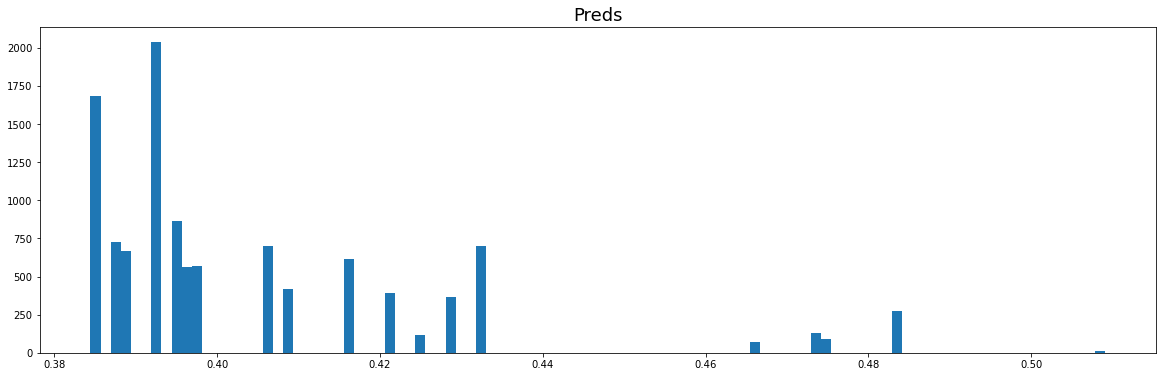

,image_name,target
0,ISIC_0052060,0.432423
1,ISIC_0052349,0.392301
2,ISIC_0058510,0.397938
3,ISIC_0073313,0.388369
4,ISIC_0073502,0.387059
5,ISIC_0074618,0.396227
6,ISIC_0076801,0.394901
7,ISIC_0077586,0.396227
8,ISIC_0082004,0.387059
9,ISIC_0082785,0.428956


,target
count,10982.000000
mean,0.403740
std,0.022780
min,0.384418
25%,0.388369
50%,0.394901
75%,0.416479
max,0.509074


In [14]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)